# Genre vs Audio Features
---

### Analysis

 

### API Authentication

In [2]:
# Dependencies
import requests
from config import client_ID
from config import client_secret
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Setup get requests URL and authentation. 
# This auto-generates an access token using your API Client ID and Client Secret each time you make a request
api_url = "https://api.spotify.com/v1/"
search_url = api_url + "search"

def authenticate_spotify_client(client_ID, client_secret):
    auth_url = "https://accounts.spotify.com/api/token"
    auth_response = requests.post(auth_url, {
        'grant_type': 'client_credentials',
        'client_id': client_ID,
        'client_secret': client_secret,
      })
    auth_response_data = auth_response.json()
    access_token = auth_response_data['access_token']
    return access_token

access_token = authenticate_spotify_client(client_ID, client_secret)

In [4]:
# Define an input to generate playlist track data
def search_playlist(playlist_id):
    playlist_api = "https://api.spotify.com/v1/playlists/"
    playlist_url = playlist_api + playlist_id +f"/tracks"
    headers = {
        'Authorization': 'Bearer {token}'.format(token=access_token)
    }
    params = {
        'market': 'AU'
    }
    response = requests.get(playlist_url, headers=headers, params=params)
    data = response.json()
    return data["items"]

In [5]:
# Define an input to generate track audio features
def search_track(track_id):
    track_api = "https://api.spotify.com/v1/audio-features/"
    track_url = track_api + track_id
    headers = {
        'Authorization': 'Bearer {token}'.format(token=access_token)
    }
    response = requests.get(track_url, headers=headers)
    data = response.json()
    return data

In [6]:
# Save a dictionary of playlist ID to call from Spotify API
playlist_id_data = {
    "rock": "37i9dQZF1EQpj7X7UK8OOF", 
    "drum_and_bass": "37i9dQZF1EIherXksVvnrN", 
    "death_metal": "37i9dQZF1EIf78r65WuXwA", 
    "hip-hop": "37i9dQZF1EQnqst5TRi17F", 
    "country": "37i9dQZF1EQmPV0vrce2QZ", 
    "pop": "37i9dQZF1EQncLwOalG3K7"
}

# Create empty list to fill with Spotify IDs to be called
audio_analysis_summary = {"Genre": [], 
                          "Playlist_ID": [], 
                          "Track_ID": []}

### Genre Means and Distribution

In [7]:
# Get the track ID for each song in each playlist using a for loop
for playlist_id in playlist_id_data:

    # Getting playlist data for each playlist ID
    playlist = search_playlist(playlist_id_data[playlist_id])

    # Counter to iterate through playlist data list
    n = 0
    
    # Go through all tracks and save the track ID to the list
    for i in playlist:
        audio_analysis_summary["Track_ID"].append(playlist[n]["track"]["id"])
        audio_analysis_summary["Genre"].append(playlist_id)
        audio_analysis_summary["Playlist_ID"].append(playlist_id_data[playlist_id])
        n = n + 1

In [33]:
# Convert to dataframe
audio_analysis_summary = pd.DataFrame(audio_analysis_summary)

In [9]:
# Create a variable to get audio features for each track ID  from the Spotify API
track_ID = audio_analysis_summary["Track_ID"]

# Create empty list for audio features data
track_audio_analysis = {"Track_ID": [],
                        "danceability": [],
                        "energy": [],
                        "loudness": [],
                        "acousticness": [],
                        "instrumentalness": [],
                        "liveness": [],
                        "valence": [],
                        "tempo": []
                       }

# Save audio features to the list
for track in track_ID:
    track_audio_data = search_track(track)
    track_audio_analysis["Track_ID"].append(track)
    track_audio_analysis["danceability"].append(track_audio_data["danceability"])
    track_audio_analysis["energy"].append(track_audio_data["energy"])
    track_audio_analysis["loudness"].append(track_audio_data["loudness"])
    track_audio_analysis["acousticness"].append(track_audio_data["acousticness"])
    track_audio_analysis["instrumentalness"].append(track_audio_data["instrumentalness"])
    track_audio_analysis["liveness"].append(track_audio_data["liveness"])
    track_audio_analysis["valence"].append(track_audio_data["valence"])
    track_audio_analysis["tempo"].append(track_audio_data["tempo"])

In [39]:
# Convert to dataframe
track_audio_analysis = pd.DataFrame(track_audio_analysis)

# Merge the data frames
track_analysis = pd.merge(audio_analysis_summary, track_audio_analysis, how="left", on=["Track_ID","Track_ID"])
track_analysis.head(3)

Genre             Playlist_ID                Track_ID  danceability  energy  \
0  rock  37i9dQZF1EQpj7X7UK8OOF  4BP3uh0hFLFRb5cjsgLqDh         0.640   0.663   
1  rock  37i9dQZF1EQpj7X7UK8OOF  1JSTJqkT5qHq8MDJnJbRE1         0.820   0.452   
2  rock  37i9dQZF1EQpj7X7UK8OOF  60a0Rd6pjrkxjPbaKzXjfq         0.556   0.864   

   loudness  acousticness  instrumentalness  liveness  valence    tempo  
0    -7.516       0.20100           0.00806    0.1520    0.663  132.770  
1    -9.796       0.54300           0.00294    0.0714    0.740  117.401  
2    -5.870       0.00958           0.00000    0.2090    0.400  105.143

In [40]:
# Average value for tracks of each genre
audio_mean = pd.DataFrame({"Danceability": track_analysis.groupby(["Genre"])["danceability"].mean(),
                           "Energy": track_analysis.groupby(["Genre"])["energy"].mean(),
                           "Loudness": track_analysis.groupby(["Genre"])["loudness"].mean(),
                           "Acousticness": track_analysis.groupby(["Genre"])["acousticness"].mean(),
                           "Instrumentalness": track_analysis.groupby(["Genre"])["instrumentalness"].mean(),
                           "Liveness": track_analysis.groupby(["Genre"])["liveness"].mean(),
                           "Valence": track_analysis.groupby(["Genre"])["valence"].mean(),
                           "Tempo": track_analysis.groupby(["Genre"])["tempo"].mean()
                          })

audio_mean.head(3)

Danceability   Energy  Loudness  Acousticness  \
Genre                                                          
country             0.56784  0.57468  -7.28798      0.351710   
death_metal         0.35016  0.93722  -5.76456      0.000344   
drum_and_bass       0.55230  0.87058  -3.14776      0.049614   

               Instrumentalness  Liveness   Valence      Tempo  
Genre                                                           
country                0.001955  0.146506  0.474560  119.95554  
death_metal            0.413084  0.228660  0.268878  118.39464  
drum_and_bass          0.098785  0.215868  0.336012  139.86554

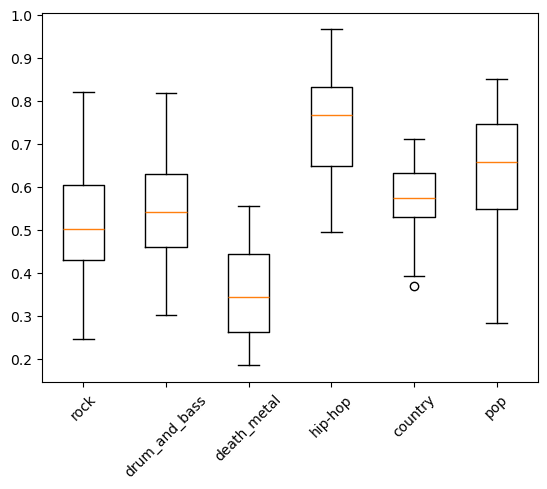

In [12]:
# Find the distribution of the danceability audio feature for each genre

# Create a list of each genre
genre_ID = {"rock":[], 
            "drum_and_bass": [], 
            "death_metal": [],
            "hip-hop": [],
            "country": [], 
            "pop": []
}

# Iterate through all of the tracks and add to the list
for genre in genre_ID:
    mask = track_analysis.loc[track_analysis["Genre"] == genre]
    dance = mask["danceability"].tolist()
    genre_ID[genre] = dance

# Plot on a boxplot
labels, data = [*zip(*genre_ID.items())] 
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
plt.show()

### Variance

In [41]:
# Calculating variance of 
genre_variance_data = pd.DataFrame({"Danceability": track_analysis.groupby(["Genre"])["danceability"].var(),
                           "Energy": track_analysis.groupby(["Genre"])["energy"].var(),
                           "Loudness": track_analysis.groupby(["Genre"])["loudness"].var(),
                           "Acousticness": track_analysis.groupby(["Genre"])["acousticness"].var(),
                           "Instrumentalness": track_analysis.groupby(["Genre"])["instrumentalness"].var(),
                           "Liveness": track_analysis.groupby(["Genre"])["liveness"].var(),
                           "Valence": track_analysis.groupby(["Genre"])["valence"].var(),
                           "Tempo": track_analysis.groupby(["Genre"])["tempo"].var()
                          })

genre_variance_data.head(3)

Danceability    Energy  Loudness  Acousticness  \
Genre                                                           
country            0.006855  0.040638  6.543827  6.653024e-02   
death_metal        0.009741  0.005576  7.919430  7.726111e-07   
drum_and_bass      0.015273  0.009694  3.717555  5.828304e-03   

               Instrumentalness  Liveness   Valence        Tempo  
Genre                                                             
country                0.000065  0.010584  0.041868  1068.534625  
death_metal            0.139183  0.025490  0.023897   540.469719  
drum_and_bass          0.040286  0.027252  0.042405  1833.118435

In [14]:
# creating a dictonary with total variance
genre_variance1 = {"country": "", 
            "death_metal": "", 
            "drum_and_bass": "",
            "hip-hop": "",
            "pop": "", 
            "rock": ""
}

# reseting the index so that genre becomes a normal column
genre_reset = genre_variance_data.reset_index()

#columsn to iterate through
columns1 = ['Danceability',
           'Energy',
           'Loudness',
           'Acousticness',
           'Instrumentalness',
           'Liveness',
           'Valence',
           'Tempo']

# Calculate total variance for each genre. Note that Var(X + Y) = Var(X) + Var(Y)
n = 0
total = 0
for genre in genre_variance1:
    mask = genre_reset.loc[genre_reset["Genre"] == genre]
    for column in columns1:
        total = total + mask[column][n]
        genre_variance1[genre] = total
    total = 0
    n = n + 1

# create a new dataframe
genre_variance1 = pd.DataFrame(genre_variance1.items(),columns=["Genre", "Total Var. Incl. Loudness and Tempo"])

# assign a rank to the new variance summary
genre_variance1["Rank Incl. Loudness and Tempo"] = genre_variance1.sort_values(by=["Total Var. Incl. Loudness and Tempo"], ascending=False) \
               .reset_index() \
               .sort_values("index") \
               .index + 1

In [15]:
# The loudness and tempo audio features skews the data as this data is based on dP and BPM, whereas the others are on a lienar scale of 0.00 to 1.00. 
# Therefore we will compare the previous data with new data that removes this column.
# creating a dictonary with total variance
genre_variance2 = {"country": "", 
            "death_metal": "", 
            "drum_and_bass": "",
            "hip-hop": "",
            "pop": "", 
            "rock": ""
}

# columns that exclude tempo and loudness
columns2 = ['Danceability',
           'Energy',
           'Acousticness',
           'Instrumentalness',
           'Liveness',
           'Valence']

# Calculate total variance for each genre. Note that Var(X + Y) = Var(X) + Var(Y)
n = 0
total = 0
for genre in genre_variance2:
    mask = genre_reset.loc[genre_reset["Genre"] == genre]
    for column in columns2:
        total = total + mask[column][n]
        genre_variance2[genre] = total
    total = 0
    n = n + 1

# create a new dataframe
genre_variance2 = pd.DataFrame(genre_variance2.items(),columns=["Genre", "Total Var. Excl. Loudness and Tempo"])

# assign a rank to the new variance summary
genre_variance2["Rank Excl. Loudness and Tempo"] = genre_variance2.sort_values(by=["Total Var. Excl. Loudness and Tempo"], ascending=False) \
               .reset_index() \
               .sort_values("index") \
               .index + 1

In [16]:
# Merge both variance dataframes
merge_variance = pd.merge(genre_variance1, genre_variance2, how="left", on=["Genre","Genre"])

merge_variance

Genre  Total Var. Incl. Loudness and Tempo  \
0        country                          1075.244994   
1    death_metal                           548.593037   
2  drum_and_bass                          1836.976728   
3        hip-hop                          1069.295923   
4            pop                           507.444116   
5           rock                           790.422618   

   Rank Incl. Loudness and Tempo  Total Var. Excl. Loudness and Tempo  \
0                              2                             0.166542   
1                              5                             0.203888   
2                              1                             0.140738   
3                              3                             0.155203   
4                              6                             0.119054   
5                              4                             0.127796   

   Rank Excl. Loudness and Tempo  
0                              2  
1                              1  
2                              4  
3                              3  
4                              6  
5                              5

<function matplotlib.pyplot.show(close=None, block=None)>

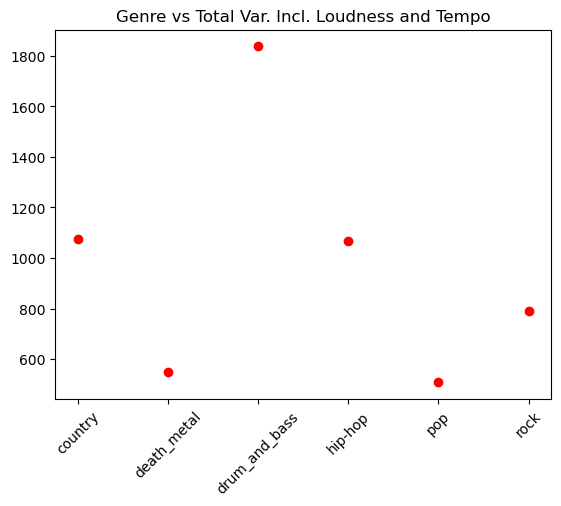

In [30]:
plt.scatter(merge_variance["Genre"], merge_variance["Total Var. Incl. Loudness and Tempo"], color="r", label="Total Var. Incl. Loudness and Tempo") 
plt.xticks(rotation=45)
plt.title("Genre vs Total Var. Incl. Loudness and Tempo")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

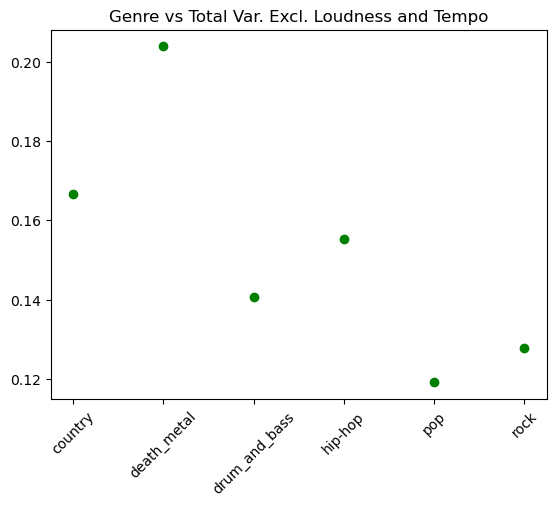

In [31]:
plt.scatter(merge_variance["Genre"], merge_variance["Total Var. Excl. Loudness and Tempo"], color="g", label="Total Var. Excl. Loudness and Tempo")
plt.xticks(rotation=45)
plt.title("Genre vs Total Var. Excl. Loudness and Tempo")
plt.show